# 1st trial model LeNet on the COVID-19 CXR images dataset
In this notebook, we concider data arrengement in the 3 groups directly (no Tran, test, va yet).
We also consider masks are applied on images and normalized data are sve in dedicated directory

## 1- Data preparation
Loading data from directory, ensuring shape of feature, put in array and creat target data/

In [1]:
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os


In [2]:
base_path = r'C:\Users\tomba\Documents\GitHub\MAR24_BDS_Radios_Pulmonaire\data\processed\Lung Segmentation Data'

In [3]:
def images_to_array(directory, stop_crit):
    image_list = []
    init_crit = 0
    for filename in tqdm(os.listdir(directory)):
        if (filename.endswith(".jpg") or filename.endswith(".png")) and (init_crit < stop_crit): 
            img = cv2.imread(os.path.join(directory, filename),  cv2.IMREAD_GRAYSCALE)
            #img_resized = cv2.resize(img, target_shape)
            img_array = np.array(img)
            image_list.append(img_array)
            init_crit += 1
    final_array = np.concatenate(image_list, axis=0)
    
    return final_array

In [39]:
features = []
targets = []
for group in os.listdir(base_path):
    img_mask_dir = os.path.join(base_path, group, 'images')
    features.append(images_to_array(img_mask_dir, 1100))
    group_label = np.array([group]*1100)  # Creating target labels
    targets.append(group_label)
    

features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)
features = features.reshape((-1, 256, 256, 1))

    

100%|██████████| 10701/10701 [00:01<00:00, 8460.81it/s]


In [40]:
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(targets)

In [41]:
print("Features shape:", features.shape)
print("Targets encoded shape:", targets_encoded.shape)

Features shape: (3300, 256, 256, 1)
Targets encoded shape: (3300,)


Text(0.5, 1.0, 'Non-COVID -> 1')

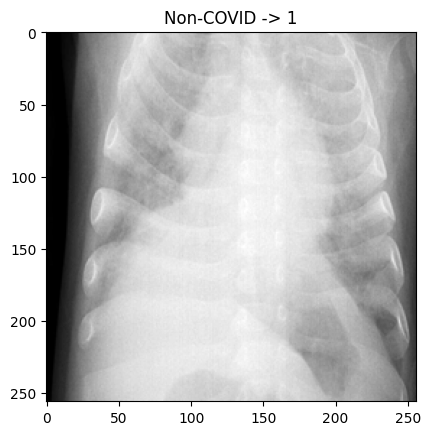

In [42]:
rd_masked_image =np.random.choice(len(features))
plt.imshow(features[rd_masked_image], cmap='gray')
plt.title(targets[rd_masked_image] +' -> ' + str(targets_encoded[rd_masked_image]))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, targets_encoded, test_size=0.2, shuffle=True)
del features, targets_encoded, targets

In [44]:
from sklearn.preprocessing import OneHotEncoder
# Step 1: Reshape the target variable to a column vector
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Step 2: One-Hot Encoding
encoder = OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train).toarray()
y_test = encoder.fit_transform(y_test).toarray()

X_train = X_train/255
X_test = X_test/255

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn import metrics


In [11]:
# Architecture du modèle
inputs=Input(shape = (256, 256,1), name = "Input")


conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (256, 256, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = 0.2)

dense_1 = Dense(units = 128,
                activation = 'relu')

dense_2 = Dense(units = 3,
                activation = 'softmax')
x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)


x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)




c:\Users\tomba\Documents\GitHub\COVID-QU-Ex-Dataset_analysis\myenv_project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:
all_val_accuracy=[]

## a-Images data NOT normalized
Scaled (/255) but not normalized


In [12]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation
training_history_lenet = lenet.fit(X_train, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs



Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.3794 - loss: 1.7948 - val_accuracy: 0.6515 - val_loss: 0.9789
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6390 - loss: 0.9001 - val_accuracy: 0.8049 - val_loss: 0.6305
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7702 - loss: 0.5863 - val_accuracy: 0.7557 - val_loss: 0.5600
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7692 - loss: 0.5718 - val_accuracy: 0.8068 - val_loss: 0.5169
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7982 - loss: 0.5026 - val_accuracy: 0.8352 - val_loss: 0.4492
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8074 - loss: 0.4700 - val_accuracy: 0.8409 - val_loss: 0.4428
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8431 - loss: 0.4382 - val_accuracy: 0.8617 - val_loss: 0.4050
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.8653 - loss: 0.3908 - val_accuracy: 0.8485 - val_loss:

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       213
           1       0.99      0.93      0.96       223
           2       0.90      0.91      0.91       224

    accuracy                           0.93       660
   macro avg       0.93      0.93      0.93       660
weighted avg       0.93      0.93      0.93       660



col_0,0,1,2
row_0,,,
0,199,1,13
1,6,208,9
2,18,2,204


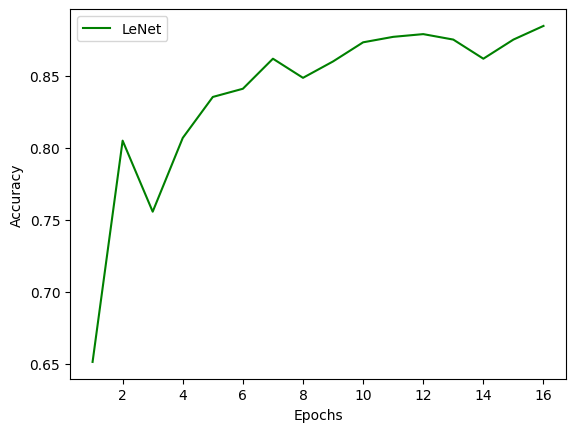

In [33]:
train_acc_lenet = training_history_lenet.history['accuracy']
all_val_accuracy.append(training_history_lenet.history['val_accuracy'])


# Results
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[0], 
         label = 'LeNet',
         color = 'green')

plt.legend()


test_pred_lenet = lenet.predict(X_test)
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class))
pd.crosstab(y_test_class, test_pred_lenet_class)

## b- Image data NORMALIZED

In [45]:
X_train *= 255
X_test *= 255

In [46]:
def normalize (data):
    init=[]
    for i, array in enumerate(data):

            min_val = np.min(array)
            max_val = np.max(array)

            if max_val - min_val == 0:
                normalized_array = np.zeros_like(array, dtype=np.float32)
            else:
                normalized_array = (array - min_val) / (max_val - min_val)
            init.append(normalized_array)

    return np.concatenate(init, axis=0)

In [47]:
X_train = normalize(X_train).reshape(-1, 256, 256, 1)
X_test = normalize(X_test).reshape(-1, 256, 256, 1)

In [49]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation
training_history_lenet = lenet.fit(X_train, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7534 - loss: 1.1165 - val_accuracy: 0.8428 - val_loss: 0.4867
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8383 - loss: 0.4698 - val_accuracy: 0.8750 - val_loss: 0.4179
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8683 - loss: 0.3982 - val_accuracy: 0.8826 - val_loss: 0.4033
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.8844 - loss: 0.3495 - val_accuracy: 0.8845 - val_loss: 0.3740
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8799 - loss: 0.3424 - val_accuracy: 0.8920 - val_loss: 0.3510
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9041 - loss: 0.3045 - val_accuracy: 0.8845 - val_loss: 0.3462
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9057 - loss: 0.2925 - val_accuracy: 0.8920 - val_loss: 0.3405
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9084 - loss: 0.2578 - val_accuracy: 0.8977 - val_loss:

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       205
           1       0.98      0.92      0.95       231
           2       0.89      0.92      0.90       224

    accuracy                           0.92       660
   macro avg       0.92      0.91      0.91       660
weighted avg       0.92      0.92      0.92       660



col_0,0,1,2
row_0,,,
0,186,3,16
1,9,213,9
2,18,1,205


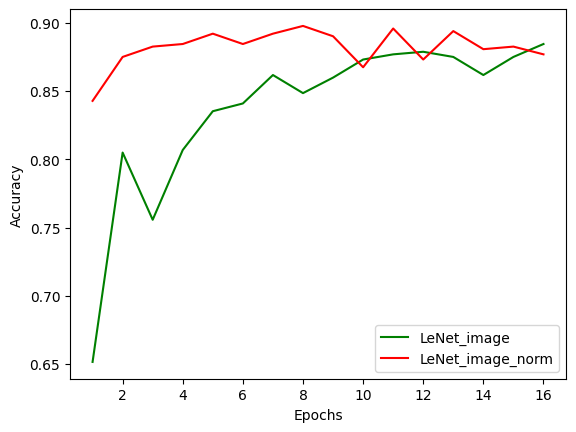

In [50]:
train_acc_lenet = training_history_lenet.history['accuracy']
all_val_accuracy.append(training_history_lenet.history['val_accuracy'])


# Results
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[0], 
         label = 'LeNet_image',
         color = 'green')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[1], 
         label = 'LeNet_image_norm',
         color = 'red')         

plt.legend()


test_pred_lenet = lenet.predict(X_test)
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class))
pd.crosstab(y_test_class, test_pred_lenet_class)

## c- Masked image NOT NORMALIZED

In [51]:
features = []
targets = []
for group in os.listdir(base_path):
    img_mask_dir = os.path.join(base_path, group, 'masked images')
    features.append(images_to_array(img_mask_dir, 1100))
    group_label = np.array([group]*1100)  # Creating target labels
    targets.append(group_label)
    

features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)
features = features.reshape((-1, 256, 256, 1))

100%|██████████| 10701/10701 [00:00<00:00, 12841.97it/s]


In [52]:
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(targets)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features, targets_encoded, test_size=0.2, shuffle=True)
del features, targets_encoded, targets

In [54]:
from sklearn.preprocessing import OneHotEncoder
# Step 1: Reshape the target variable to a column vector
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Step 2: One-Hot Encoding
encoder = OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train).toarray()
y_test = encoder.fit_transform(y_test).toarray()

X_train = X_train/255
X_test = X_test/255

In [55]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation
training_history_lenet = lenet.fit(X_train, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.4723 - loss: 3.0394 - val_accuracy: 0.5530 - val_loss: 1.1569
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.6333 - loss: 0.9286 - val_accuracy: 0.6856 - val_loss: 0.7820
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.7118 - loss: 0.6930 - val_accuracy: 0.7500 - val_loss: 0.6968
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7649 - loss: 0.6060 - val_accuracy: 0.7500 - val_loss: 0.6670
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7884 - loss: 0.5558 - val_accuracy: 0.7670 - val_loss: 0.6324
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7936 - loss: 0.5209 - val_accuracy: 0.7708 - val_loss: 0.6127
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7975 - loss: 0.5070 - val_accuracy: 0.7746 - val_loss: 0.5887
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.8172 - loss: 0.4817 - val_accuracy: 0.7879 - val_loss:

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step
              precision    recall  f1-score   support

           0       0.76      0.84      0.79       226
           1       0.82      0.76      0.79       215
           2       0.77      0.74      0.75       219

    accuracy                           0.78       660
   macro avg       0.78      0.78      0.78       660
weighted avg       0.78      0.78      0.78       660



col_0,0,1,2
row_0,,,
0,189,12,25
1,28,163,24
2,33,24,162


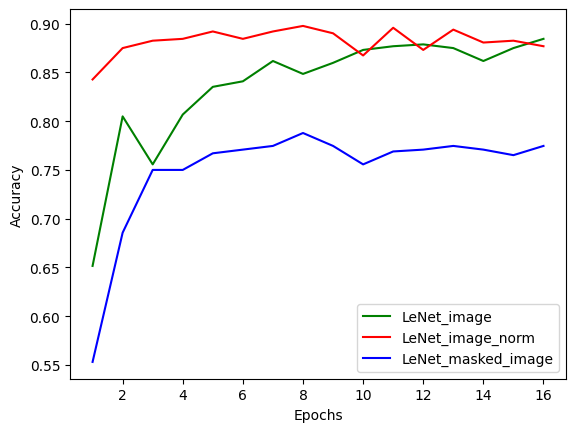

In [56]:
train_acc_lenet = training_history_lenet.history['accuracy']
all_val_accuracy.append(training_history_lenet.history['val_accuracy'])


# Results
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[0], 
         label = 'LeNet_image',
         color = 'green')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[1], 
         label = 'LeNet_image_norm',
         color = 'red')         
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[2], 
         label = 'LeNet_masked_image',
         color = 'blue')  
plt.legend()


test_pred_lenet = lenet.predict(X_test)
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class))
pd.crosstab(y_test_class, test_pred_lenet_class)